In [1]:
import illustris_python as il
import mistree as mist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.units as u
import astropy.constants as c
import pandas as pd
import networkx as nx
import seaborn as sns
import scienceplots

from sklearn.neighbors import radius_neighbors_graph, KernelDensity
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.spatial import Delaunay
from scipy.spatial.distance import euclidean, minkowski

import Utilities as ut
import Network_stats as ns

plt.style.use(['science','no-latex'])


We can't use spearman's correlation coefficient to estimate the theoretical classification accuracy. That was wrong.

We can estimate it by calculating the Bayes error rate: E_Bayes

In [2]:
# Load data
test = ns.network(masscut=1e9)
G = test.subhalo_delauany_network(xyzplot=False)
test.cweb_classify(xyzplot=False)
test.network_stats_delaunay()

There are 283969 subhalos with stellar mass greater than 0.06774.
length before buffering:  283969
length after buffering:  283969


In [22]:
test.data

,Degree,Mean E.L.,Min E.L.,Max E.L.,Clustering,Density,Neigh Density,Target
Node ID,,,,,,,,
0,3.979139,0.209428,0.118046,0.325785,0.000212,375.917254,918.529071,3.0
1,2.049505,0.146393,0.070603,0.229360,0.000201,2160.114017,1998.211532,3.0
2,3.176717,0.317672,0.032403,0.551327,0.000677,129.093631,48.940531,3.0
3,7.288932,0.560687,0.044699,1.320098,0.000749,8.441823,314.851165,3.0
4,4.030514,0.403051,0.047626,0.714933,0.000687,45.007940,15.812897,3.0
...,...,...,...,...,...,...,...,...
283964,9.076247,1.296607,0.517913,3.402012,0.003265,0.788000,0.501807,3.0
283965,33.390793,2.226053,0.304603,3.200867,0.002756,0.076768,0.102348,3.0
283966,61.446798,3.234042,0.879060,8.516660,0.003286,0.008032,0.664860,3.0


In [41]:
nx.average_degree_connectivity(G, weight='length')

{19: 19.589431979728747,
 14: 19.553630750822776,
 10: 19.521808324709195,
 13: 19.598274307468728,
 12: 19.538503684064064,
 9: 19.3798988598884,
 7: 19.185974888770726,
 16: 19.523763097285396,
 15: 19.610749606368106,
 18: 19.56990837869071,
 8: 19.28931773229488,
 17: 19.600081027806254,
 20: 19.663960076858665,
 21: 19.656955876207363,
 11: 19.54825259558375,
 24: 19.64315736297249,
 23: 19.7903841813408,
 25: 19.77464760540191,
 22: 19.72096882199959,
 5: 18.112948522310692,
 27: 20.11547579791153,
 29: 19.907320535136193,
 28: 19.973206245605198,
 6: 18.861188328690485,
 26: 19.788210868503764,
 33: 20.737831247883403,
 32: 20.741970042841512,
 34: 21.388680644515375,
 31: 20.504936069375336,
 4: 17.994442503837092,
 30: 20.235861938237296,
 41: 22.40213542043005,
 35: 20.94549786313951,
 36: 21.99286570901619,
 53: 27.84410628593578,
 38: 21.38972688888974,
 45: 24.098471123586357,
 40: 23.262910985323867,
 39: 22.61374417318056,
 42: 22.784231395729382,
 44: 24.10291131121804,

In [23]:
features = test.data.iloc[:,:-1] # All columns except the last one
targets = test.data.iloc[:,-1] # The last column

# scaler = PowerTransformer()
scaler = PowerTransformer(method = 'box-cox')
features = pd.DataFrame(scaler.fit_transform(features), index=features.index, columns=features.columns)

In [24]:
targets
targets

Node ID
0         3.0
1         3.0
2         3.0
3         3.0
4         3.0
         ... 
283964    3.0
283965    3.0
283966    3.0
283967    3.0
283968    2.0
Name: Target, Length: 283969, dtype: float64

In [9]:
# function to calculate class conditional probabilities P(X|Y=c) for each class
def class_conditional(X, bandwidth=0.1):
    '''
    Calculate the class conditional
    X: features
    bandwidth: bandwidth of the kernel density estimator
    '''
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(X)
    return kde

# function to calculate class priors P(Y=c)
def class_priors(Y):
    '''
    Calculate the class priors
    Y: targets
    '''
    priors = Y.value_counts(normalize=True)
    return np.array(priors)

# function to calculate the posterior probability P(Y=c|X)
def posterior(X, class_kdes, cp):
    '''
    Calculate the posterior probability
    X: features
    class_kdes: class conditional
    cp: class priors
    '''
    n_classes = len(class_kdes)
    n_samples = X.shape[0]

    densities = np.zeros((n_samples, n_classes)) # initialize array to hold densities

    # calculating P(X|Y=c) for each class
    for c in range(n_classes):
        densities[:, c] = np.exp(class_kdes[c].score_samples(X)) # log density to density

    # calculate the marginal
    evidence = densities[:,0]*cp[0] + densities[:,1]*cp[1] + densities[:,2]*cp[2] + densities[:,3]*cp[3]

    # calculate the posterior
    posteriors = densities * cp / evidence[:, None]
    return posteriors

# function for Bayes error rate
def bayes_error_rate(posteriors):
    '''
    Calculate the Bayes error rate
    '''
    max_posterior = np.max(posteriors, axis=1) # find the maximum posterior probability
    error_rate = 1 - np.mean(max_posterior) # calculate the error rate
    return error_rate


In [10]:
classes = np.unique(targets) # unique classes
cp = class_priors(targets) # P(Y) for each class
n_classes = len(classes) # number of classes

# calculate class conditional densities
class_kdes = []
for c in classes:
    X_c = features[targets == c] # features for class c
    kde_c = class_conditional(X_c, bandwidth=0.1) # class conditional for class c
    class_kdes.append(kde_c)

# calculate posterior probabilities
posteriors = posterior(features, class_kdes, cp)

KeyboardInterrupt: 

In [11]:
# For the entire dataset

E_B = bayes_error_rate(posteriors)
print(f'Theoretical limit for accuracy from Bayes error rate: {100*(1 - E_B):.2f}%')

NameError: name 'posteriors' is not defined

In [12]:
train_x, test_x, train_y, test_y = train_test_split(features, targets, test_size=0.2, random_state=42, stratify=targets)
valid_x, test_x, valid_y, test_y = train_test_split(test_x, test_y, test_size=0.2, random_state=42, stratify=test_y)

In [13]:
train_x

,Degree,Mean E.L.,Min E.L.,Max E.L.,Clustering,Density,Neigh Density
Node ID,,,,,,,
92639,0.592954,0.084083,0.177724,0.497434,-0.377036,-0.259845,0.203388
249640,-0.692662,-0.400479,0.068938,-0.542606,0.191564,0.511791,-0.093263
4032,-0.257424,-0.792625,0.138416,-0.997612,-1.296693,0.678246,0.723698
163945,0.020935,0.060553,-0.539574,0.162037,0.122798,-0.039891,-0.519555
250964,0.325524,0.489049,0.228407,0.315135,0.653985,-0.447066,-0.782270
...,...,...,...,...,...,...,...
212326,-0.130413,0.433023,-0.087456,0.371276,1.519136,-0.190070,-1.383913
4668,-0.958141,-1.311520,-0.510871,-1.501367,-1.598654,1.237786,1.153189
104181,-0.860099,-0.896010,-1.532512,-0.763202,-0.851713,0.890413,0.528436


In [14]:
valid_x

,Degree,Mean E.L.,Min E.L.,Max E.L.,Clustering,Density,Neigh Density
Node ID,,,,,,,
263430,-0.383525,-0.466213,0.117728,-0.193980,-0.454535,0.378580,0.518635
139157,0.097463,-0.073164,0.507865,-0.161023,-0.274796,0.099275,-0.032295
170964,0.099043,0.080387,-0.695866,0.074840,0.148277,-0.062593,-0.258868
89195,-0.169053,-0.106720,-1.328701,0.316108,-0.186244,-0.165101,1.495958
182779,0.096406,0.370275,1.409969,-0.121472,1.012959,-0.350767,-1.167392
...,...,...,...,...,...,...,...
110038,0.106774,0.652147,-1.031530,0.977961,1.542186,-0.056978,-0.694389
212381,0.368568,0.453765,1.135298,0.162420,0.514566,-0.433733,-0.609050
156385,0.096101,0.260876,0.315070,0.331706,0.555189,-0.088972,0.487112


In [15]:
test_x

,Degree,Mean E.L.,Min E.L.,Max E.L.,Clustering,Density,Neigh Density
Node ID,,,,,,,
244547,0.001811,-0.049215,0.753430,-0.322006,-0.009148,0.004057,-0.241541
181063,0.256920,0.211782,1.118923,-0.022354,0.377693,-0.108636,-0.043987
118307,-1.174048,-0.432881,-0.892574,-0.311171,0.694137,0.856667,-1.394763
106836,-0.367347,0.420259,-1.016414,0.908376,1.207463,-0.083911,-0.785797
159031,-0.220190,0.026262,1.036516,-0.292942,0.658214,0.025057,-0.792461
...,...,...,...,...,...,...,...
258725,0.014001,0.051115,-0.106248,-0.072351,0.193931,0.003921,-0.499965
109598,0.191121,0.123149,-0.560221,0.042811,-0.005126,-0.148201,-0.124912
27377,-1.132581,-1.476401,-0.721762,-1.487477,-1.694572,1.323427,1.558791


The bandwidth is a hyperparameter in KDE that controls the smooothness of the estimated density. A well-chosen bandwigth balances the trade-off between underfitting and overfitting:

- Small bandwidth: Creates highly detailed density estimate, but leads to overfitting (too spiky).

- Large bandwidth: Smooths out the density estimation, but it may lead to underfitting (too broad and inaccurate).

In [36]:
frequencies = dict(train_y.value_counts(normalize=True))
class_p = np.array([frequencies[0], frequencies[1], frequencies[2], frequencies[3]])
class_p


array([0.03793551, 0.24305051, 0.45084186, 0.26817211])

In [60]:
# now for a given test set

classes = np.unique(train_y) # unique classes
n_classes = len(classes) # number of classes
cp = [1,1,1,1]#class_p#class_priors(train_y) # P(Y) for each class

# calculate class conditional densities
class_kdes = []
for c in classes:
    X_c = train_x[train_y == c] # features for class c
    kde_c = class_conditional(X_c, bandwidth=0.10680004325145757) # class conditional for class c
    class_kdes.append(kde_c)

# calculate posterior probabilities
posteriors = posterior(train_x, class_kdes, cp) # test set

E_B = bayes_error_rate(posteriors)

print(f'Theoretical accuracy limit for test set from Bayes error rate: {100*(1 - E_B):.2f}%')

Theoretical accuracy limit for test set from Bayes error rate: 74.29%


In [46]:
test_x

,Degree,Mean E.L.,Min E.L.,Max E.L.,Clustering,Density,Neigh Density
Node ID,,,,,,,
244547,0.001811,-0.049215,0.753430,-0.322006,-0.009148,0.004057,-0.241541
181063,0.256920,0.211782,1.118923,-0.022354,0.377693,-0.108636,-0.043987
118307,-1.174048,-0.432881,-0.892574,-0.311171,0.694137,0.856667,-1.394763
106836,-0.367347,0.420259,-1.016414,0.908376,1.207463,-0.083911,-0.785797
159031,-0.220190,0.026262,1.036516,-0.292942,0.658214,0.025057,-0.792461
...,...,...,...,...,...,...,...
258725,0.014001,0.051115,-0.106248,-0.072351,0.193931,0.003921,-0.499965
109598,0.191121,0.123149,-0.560221,0.042811,-0.005126,-0.148201,-0.124912
27377,-1.132581,-1.476401,-0.721762,-1.487477,-1.694572,1.323427,1.558791


In [44]:
np.max(posteriors, axis=1)

array([0.84371875, 0.77427116, 0.55044152, ..., 0.95080746, 0.80459726,
       0.95575757])

In [19]:

# from sklearn.decomposition import PCA

# pca = PCA(n_components=4) # we want to reduce the information to 4 dimensions that should represent each cosmic web environment

# X_pca = pca.fit_transform(features)

In [21]:
# print(pca.explained_variance_)
# print(pca.explained_variance_ratio_)
# pca.explained_variance_ratio_.cumsum()

[5.90398962 0.58453327 0.33950161 0.11311552]
[0.84342412 0.08350446 0.04850006 0.0161593 ]


array([0.84342412, 0.92692858, 0.97542864, 0.99158794])

In [ ]:
# train_xpca, test_xpca, train_ypca, test_ypca = train_test_split(X_pca, targets, test_size=0.2, random_state=42, stratify=targets)
# valid_xpca, test_xpca, valid_ypca, test_ypca = train_test_split(test_xpca, test_ypca, test_size=0.2, random_state=42, stratify=test_ypca)

In [18]:
classes
weights = np.array([0.7237, 0.1130, 0.0609, 0.1024])

In [60]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier(learning_rate=0.1, random_state=42, verbose=1, class_weight=dict(zip(classes, weights)), max_iter=1000)
model.fit(train_x, train_y)


Binning 0.011 GB of training data: 0.194 s
Binning 0.001 GB of validation data: 0.002 s
Fitting gradient boosted rounds:
[1/1000] 4 trees, 124 leaves (31 on avg), max depth = 10, train loss: 1.22098, val loss: 1.22149, in 0.125s
[2/1000] 4 trees, 124 leaves (31 on avg), max depth = 9, train loss: 1.10516, val loss: 1.10628, in 0.114s
[3/1000] 4 trees, 124 leaves (31 on avg), max depth = 9, train loss: 1.01939, val loss: 1.02129, in 0.115s
[4/1000] 4 trees, 124 leaves (31 on avg), max depth = 9, train loss: 0.95375, val loss: 0.95612, in 0.116s
[5/1000] 4 trees, 124 leaves (31 on avg), max depth = 12, train loss: 0.90230, val loss: 0.90517, in 0.118s
[6/1000] 4 trees, 124 leaves (31 on avg), max depth = 10, train loss: 0.86145, val loss: 0.86428, in 0.115s
[7/1000] 4 trees, 124 leaves (31 on avg), max depth = 10, train loss: 0.82848, val loss: 0.83195, in 0.114s
[8/1000] 4 trees, 124 leaves (31 on avg), max depth = 11, train loss: 0.80146, val loss: 0.80518, in 0.116s
[9/1000] 4 trees, 

HistGradientBoostingClassifier(class_weight={0.0: 0.7237, 1.0: 0.113,
                                             2.0: 0.0609, 3.0: 0.1024},
                               max_iter=1000, random_state=42, verbose=1)

In [61]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
)

y_pred = model.predict(test_x)
accuracy = accuracy_score(test_y, y_pred)
f1 = f1_score(test_y, y_pred, average='weighted')
print(f'Accuracy: {accuracy:.2f}')
print(f'F1 score: {f1:.2f}')


Accuracy: 0.67
F1 score: 0.67


In [62]:
classification_report(test_y, y_pred, target_names=['Void', 'Wall', 'Filament', 'Cluster'], output_dict=True)

{'Void': {'precision': 0.32502396931927136,
  'recall': 0.7865429234338747,
  'f1-score': 0.4599728629579377,
  'support': 431.0},
 'Wall': {'precision': 0.5893593106032222,
  'recall': 0.5697211155378487,
  'f1-score': 0.5793738489871088,
  'support': 2761.0},
 'Filament': {'precision': 0.7555285540704739,
  'recall': 0.6071079867213435,
  'f1-score': 0.6732351667388481,
  'support': 5121.0},
 'Cluster': {'precision': 0.7253680634201586,
  'recall': 0.8411030860144452,
  'f1-score': 0.778960170264518,
  'support': 3046.0},
 'accuracy': 0.667576371159433,
 'macro avg': {'precision': 0.5988199743532815,
  'recall': 0.701118777926878,
  'f1-score': 0.6228855122371032,
  'support': 11359.0},
 'weighted avg': {'precision': 0.6907156645765299,
  'recall': 0.667576371159433,
  'f1-score': 0.6706795904994841,
  'support': 11359.0}}

In [63]:
classes = np.unique(targets)
classes

array([0., 1., 2., 3.])

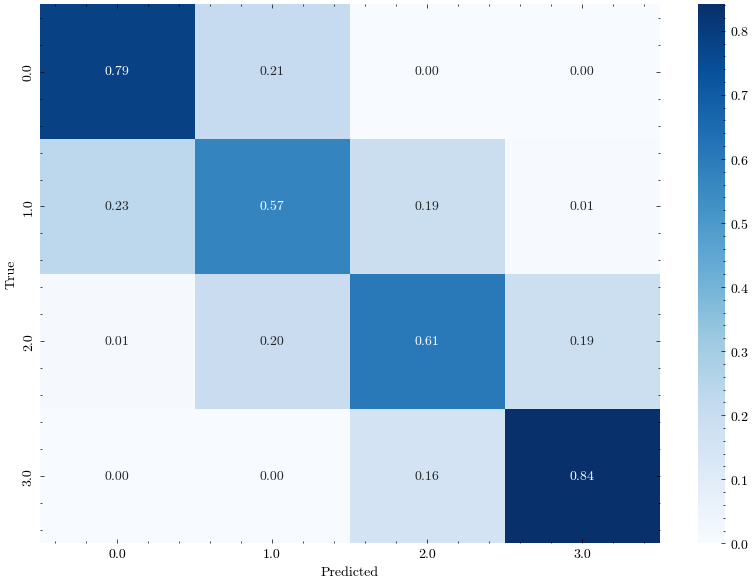

In [64]:
cm = confusion_matrix(test_y, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='.2f',cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [146]:
# maximising log likelihood for optimal bandwidth
bandwidths = np.logspace(-1.0, -0.8, 15)

grid = GridSearchCV(KernelDensity(kernel='gaussian'), param_grid={'bandwidth': bandwidths}, cv=None, verbose=2)
grid.fit(train_x)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ......................................bandwidth=0.1; total time=  22.3s
[CV] END ......................................bandwidth=0.1; total time=  22.0s
[CV] END ......................................bandwidth=0.1; total time=  21.9s
[CV] END ......................................bandwidth=0.1; total time=  22.2s
[CV] END ......................................bandwidth=0.1; total time=  22.4s
[CV] END .......................bandwidth=0.1033441063880556; total time=  22.4s
[CV] END .......................bandwidth=0.1033441063880556; total time=  22.1s
[CV] END .......................bandwidth=0.1033441063880556; total time=  22.3s
[CV] END .......................bandwidth=0.1033441063880556; total time=  22.4s
[CV] END .......................bandwidth=0.1033441063880556; total time=  22.0s
[CV] END ......................bandwidth=0.10680004325145757; total time=  22.2s
[CV] END ......................bandwidth=0.10680

GridSearchCV(estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.1       , 0.10334411, 0.10680004, 0.11037155, 0.11406249,
       0.11787686, 0.12181879, 0.12589254, 0.13010252, 0.13445329,
       0.13894955, 0.14359617, 0.14839818, 0.15336077, 0.15848932])},
             verbose=2)

In [147]:
best_bandwidth = grid.best_params_['bandwidth']

In [148]:
best_bandwidth

0.10680004325145757

In [149]:
np.logspace(-1.0, -0.8, 15)

array([0.1       , 0.10334411, 0.10680004, 0.11037155, 0.11406249,
       0.11787686, 0.12181879, 0.12589254, 0.13010252, 0.13445329,
       0.13894955, 0.14359617, 0.14839818, 0.15336077, 0.15848932])

In [49]:
import cvxpy as cvx
import math
from sklearn.neighbors import NearestNeighbors, KDTree

def get_Chebyshev_weights(L):

	d = L-2
	C = np.zeros(d)

	I = np.arange(0,L)
	# compute Chebyshev nodes
	S = 0.5*np.cos(math.pi/L*(I+0.5))+0.5
	#print(S)
	# simplified form of w_i:
	W_mat = np.zeros((L,d+1))
	for k in range(d+1):
		W_mat[:,k] = 2/L*Ts(k,0) * Ts(k,S)
	Wi = np.sum(W_mat, axis = 1) - 1/L
	return np.flip(S,axis=0), np.flip(Wi,axis=0)

#print(Wi)

def Ts(i,x):
    C = np.zeros(i+1)
    C[-1]=1
    return np.polynomial.chebyshev.chebval(2*x-1, C)


def get_arithmetic_weights(L, d):
	
	# Create optimization variables.
	cvx_eps = cvx.Variable()
	cvx_w = cvx.Variable(L)

	# Create constraints:
	constraints = [cvx.sum(cvx_w)==1, cvx.pnorm(cvx_w, 2)- cvx_eps/2 <= 0 ]
	for i in range(1,L):
		Tp = ((1.0*np.arange(1,L+1))**(1.0*i/d))
		cvx_mult = cvx.multiply(cvx_w.T , Tp)
		constraints.append(cvx.sum(cvx_mult) - cvx_eps*2 <= 0)
	
	# Form objective.
	obj = cvx.Minimize(cvx_eps)

	# Form and solve problem.
	prob = cvx.Problem(obj, constraints)
	prob.solve()  # Returns the optimal value.
	sol = np.array(cvx_w.value)

	# Find points
	S = np.arange(1,L+1)/L
	return S, sol.T

# Uniform non-optimal Weights
def get_uniform_weights(L):
	# Find points
	S = np.arange(1,L+1)/L
	W = np.ones(L)/L
	return S, W

In [56]:
# alternative BER formulation
def NN_bw(X, k0):

	nbrs = NearestNeighbors(n_neighbors=k0, algorithm='ball_tree').fit(X)
	
	if X.shape[0]>1000:
		X_test = X[:1000]
	else: 
		X_test = X
	
	distances, indices = nbrs.kneighbors(X_test)
	#print('KNN distance', np.mean(distances[:,-1]))
	return np.mean(distances[:,-1])

def cross_valid_bw(X):

	std_data = np.linalg.norm(np.std(X,axis =0))
	print('bw_CV')	
	grid = GridSearchCV(KernelDensity(kernel='tophat'),
				{'bandwidth': np.linspace(0.2*std_data, 1.5* std_data, 15)},cv=20) # 20-fold cross-validation
	grid.fit(X)
	h_cv = grid.best_params_['bandwidth']
	
	print('done', std_data, h_cv)
	return h_cv

def compute_weights(L, d, T, N):
	
	# Create optimization variables.
	cvx_eps = cvx.Variable()
	cvx_w = cvx.Variable(L)

	# Create constraints:
	constraints = [cvx.sum(cvx_w)==1, cvx.pnorm(cvx_w, 2)- cvx_eps/2 <= 0 ]
	for i in range(1,L):
		Tp = ((1.0*T/N)**(1.0*i/(2*d)))
		cvx_mult = cvx_w.T * Tp
		constraints.append(cvx.sum(cvx_mult) - cvx_eps*2 <= 0)
	
	# Form objective.
	obj = cvx.Minimize(cvx_eps)

	# Form and solve problem.
	prob = cvx.Problem(obj, constraints)
	prob.solve()  # Returns the optimal value.
	sol = np.array(cvx_w.value)

	return sol.T

def eps_neighbor_count(X,X_test,h):

	#print('h_opt',h_opt)
	#kde =KernelDensity(kernel='tophat', bandwidth=h).fit(X)
	tree = KDTree(X)
	count = tree.query_radius(X_test, r = h, count_only=True)
	#dnsty = kde.score_samples(X_test)
	#print('dnsty', np.exp(dnsty) )
	#print('density, done')
	return count

def bg_estimator(X,Y,h, N_est_all = 5000, U = 0.005):
	#U = 5 # Upper bound on the density ratio
	
	
	#print(X.shape)
	Y=Y.reshape((-1,1))
	N=X.shape[0]
	
	m=max(Y)+1
	m=int(m.item())
	N_est_all = np.min([N_est_all, N])
	N_est = int(N_est_all/m)
	#N_per_class = np.array([len(Y[(Y==i)]) for i in range(m)])
	#print(len(Y[(Y==0)])/N)
	prior = np.array([len(Y[(Y==i)])/N for i in range(m)])
	#print('prioir', prior)

	D = 0
	for i in range(1,m):
		#print('i',i)
		#print('progress: /10', i)

		#I_class=np.where(Y==i)[0]
		I_class_all=np.where(Y==i)[0]
		I_class = np.random.choice(I_class_all, size=N_est, replace=True)
		X_class=X[I_class,:]

		# the matrix of prior * densities (j, x_i), where the density is computed for x_i only based on the data with label j
		f_mat = np.array([ prior[r]*eps_neighbor_count(X[np.where(Y==r)[0],:],X[np.where(Y==i)[0],:],h=h) for r in range(i+1)])
		#print('i ',i,' f_mat.size ', f_mat.shape)
		max_ratio = np.max(f_mat[:f_mat.shape[0]-1,:], axis = 0)
		#print('max_ratio.shape',max_ratio.shape)
		#print('f_mat[:,:5]')
		#print(f_mat[:,:5])
		#print('f_mat ', np.mean(f_mat) )
		#print('max_ratio ', np.mean(max_ratio))
		#print('ratio', max_ratio/f_mat[-1,:])
		#print('density shapes' , max_ratio.shape, f_mat.shape)
		#print('mean max_ratio', np.mean(max_ratio), 'mean f_mat', np.mean(f_mat[-1,:]))
		#print('partial sum', np.mean(np.maximum((1-max_ratio/f_mat[-1,:]),0)),'i ',i)
		D += np.mean(prior[i] * np.maximum((1-max_ratio/f_mat[-1,:]),0))
		#print('D',D)

	D += prior[0]
	#print('D',D)
	#print('base estimator ', 1-D)
	return 1-D



def ensemble_bg_estimator(X,Y, L=3, k0=10, h_range = [1.0,1.5], bw_selection='auto' ,ensemble_weights='Chebyshev', N_est_all = 5000, U = 0.1):
	
	N, d = X.shape[0], X.shape[1]
	
	if L <= d+1:
		intrinsic_dim = L-2
	else: 
		intrinsic_dim = d
	#I = np.dot(I_vec, weights)
	#print('version 112')

	if ensemble_weights == 'arithmetic':
		S, W = get_arithmetic_weights(L, intrinsic_dim)
		W = W.reshape(L,)
		#print(ensemble_weights, 'arithmetic')
	
	elif ensemble_weights == 'Chebyshev':
		S, W = get_Chebyshev_weights(L)
		#print(ensemble_weights)

	elif ensemble_weights == 'decaying':
		P = np.arange(L).astype(float)
		W = np.power(2,(-P))/np.sum(np.power(2,(-P)))
	
	elif ensemble_weights == 'uniform':
		S, W = get_uniform_weights(L)
		#print(ensemble_weights, 'uniform')
	
	# Scale the nodes
	h = S*(h_range[1]-h_range[0]) + h_range[0]

	# cross-validation for computing bandwidth
	if bw_selection == 'auto':
		
		if  X.shape[0] >= 2000 or  X.shape[1]>=10: 
			base = NN_bw(X,k0)
		else: 
			base = cross_valid_bw(X)
		#bprint(base)
		h_opt = h * base

	elif bw_selection == 'KNN':
		base = NN_bw(X,k0=10)
		h_opt = h * base

	elif bw_selection == 'manual': 
		h_opt = h * np.linalg.norm(np.std(X,axis =0))

	# Find base estimates:
	B = np.array([bg_estimator(X,Y,h_opt[l], N_est_all,U) for l in range(L)])
	

	#print('Base estimators',B)
	#print('weights',W)
	E = np.dot(W,B)

	return E


In [58]:
ensemble_bg_estimator(train_x.values, train_y.values, ensemble_weights='uniform')

0.2272647801527499